# Import the necessary packages

In [32]:
import numpy as np
import pandas as pd
import math
import torch
import random
import matplotlib.pyplot as plt

# Import data and pre-process data

In [2]:
df_LookupTable = pd.read_excel('/home/kamal/Desktop/CAI-2024/DatasetUsed/FinalLookupTable.xlsx')
df_Citypair = pd.read_excel('/home/kamal/Desktop/CAI-2024/DatasetUsed/CityPair.xlsx')
#df_Citypair only contain the departure and arrival hour we need to find the duration of the flight

In [43]:
# Calculate TimeOfFlight
df_Citypair['TimeOfFlight'] = df_Citypair.apply(lambda row: (row['Arrival Hour'] - row['Departure Hour'] + 24) if (row['Arrival Hour'] - row['Departure Hour']) < 0 else (row['Arrival Hour'] - row['Departure Hour']), axis=1)

# Dropping the extra unused columns for making dataframe simple
df_flightTime = df_Citypair.drop(["Date","Departure Hour", "Arrival Hour"], axis=1)

In [44]:
# Function for calculating the average time of flight as well as the number of flights between two cities in a dataset
def calculate_average_time_of_flight(flight_data):
    new_df = flight_data.groupby(['Departure', 'Arrival']).agg(
        TimeOfFlight=('TimeOfFlight', 'mean'),
        Count=('TimeOfFlight', 'count')
    ).reset_index()

    new_df = new_df.sort_values(['Departure', 'Count'], ascending=[True, False])

    return new_df


new_dataframe = calculate_average_time_of_flight(df_flightTime)
new_dataframe = new_dataframe.reset_index(drop=True) #Just to reset the index to avoid confusion

In [45]:
#Function to find the top ten departure from the given airport
def unique_arrival_departure_single(df, airport_name):
    """
    This function takes a pandas DataFrame with 'Departure' and 'Arrival' columns, and the name of an airport.
    It returns a list of unique arrival airports for the specified departure airport.
    """
    departure_airports = df[df['Departure'] == airport_name]['Arrival'].unique()[:15] # Used already sorted dataframe and return first 10 unique value
    airports_remove= ['MYNN','CYYZ','SJU','SKBO','MUHA','MPTO','MDSD'] # To remove the international destinations from the list
    departure_airports = departure_airports.tolist()  # Convert NumPy array to list
    for item in airports_remove:
      if item in departure_airports:
        departure_airports.remove(item)
    return list(departure_airports[:10])

unique_arrival_departure_single(new_dataframe,'FLL')

['ATL', 'EWR', 'LGA', 'JFK', 'BWI', 'CLT', 'DCA', 'IAH', 'DFW', 'PHL']

In [46]:
#This function returns the time taken from departure airport to the arrival airports
def get_time_of_flight(departure, arrival_list, flight_data):
    result_data = pd.DataFrame(columns=['Arrival', 'TimeOfFlight'])
    for arrival in arrival_list:
        filtered_data = flight_data[(flight_data['Departure'] == departure) & (flight_data['Arrival'] == arrival)]
        if not filtered_data.empty:
            time_of_flight = filtered_data['TimeOfFlight'].values[0]
            result_data = pd.concat([result_data, pd.DataFrame({'Arrival': [arrival], 'TimeOfFlight': [time_of_flight]})], ignore_index=True)
    return result_data

departure = 'FLL'
arrival_list = unique_arrival_departure_single(new_dataframe,'FLL')

time_of_flights = get_time_of_flight(departure, arrival_list, df_flightTime)
time_of_flights

,Arrival,TimeOfFlight
0,ATL,2
1,EWR,3
2,LGA,2
3,JFK,2
4,BWI,3
5,CLT,2
6,DCA,3
7,IAH,2
8,DFW,2
9,PHL,2


In [47]:
#This is the function to return the time duration for the flights between the city pairs
def get_time_duration(airports,departure):
    time_of_flights = get_time_of_flight(departure, airports, df_flightTime)
    # Filter the DataFrame to include only rows with the specified airports
    airport_df = time_of_flights[time_of_flights['Arrival'].isin(airports)]

    # Return the list of TimeOfFlight values
    return airport_df['TimeOfFlight'].tolist()

airports_pair_DAB=unique_arrival_departure_single(new_dataframe,'FLL')
get_time_duration(airports_pair_DAB,'FLL')

[2, 3, 2, 2, 3, 2, 3, 2, 2, 2]

In [13]:
def get_other_mean_std(hour, airports):
    # Filter the DataFrame to include only rows with the given hour and specified airports
    airport_hour_df = df_LookupTable[(df_LookupTable['DATE'].dt.hour == hour) & (df_LookupTable['Airport'].isin(airports))]

    # Group the data by airport and hour, and calculate the mean and standard deviation of the 'Other' column
    group_mean_std = airport_hour_df.groupby(['Airport', airport_hour_df['DATE'].dt.hour])['Other'].agg(['mean', 'std']).reset_index()

    # Return a list of tuples, with each tuple containing airport, mean, and std
    return [(airport, mean, std) for airport, mean, std in zip(group_mean_std['Airport'], group_mean_std['mean'], group_mean_std['std'])]

In [14]:
#Function to generate the list of time of flights of the pair airports
def get_other_mean_std(hours, airports):
    result = []

    # Iterate over each airport and corresponding hour
    for airport, hour in zip(airports, hours):
        # Filter the DataFrame to include only rows with the given hour and specified airport
        airport_hour_df = df_LookupTable[(df_LookupTable['DATE'].dt.hour == hour) & (df_LookupTable['Airport'] == airport)]

        # Group the data by airport and hour, and calculate the mean and standard deviation of the 'Other' column
        group_mean_std = airport_hour_df.groupby(['Airport', airport_hour_df['DATE'].dt.hour])['Other'].agg(['mean', 'std']).reset_index()

        # Append the airport, mean, and std to the result list
        result.extend([(airport, mean, std) for airport, mean, std in zip(group_mean_std['Airport'], group_mean_std['mean'], group_mean_std['std'])])

    # Return the result list
    return result

In [15]:
#Function to print the capability of airport at particular hour of the day
def capability_mean_std(airport, hour):
    # Filter the DataFrame to include only rows with the given airport and hour
    airport_hour_df = df_LookupTable[(df_LookupTable['Airport'] == airport) & (df_LookupTable['DATE'].dt.hour == hour)]

    # Check if there is data available
    if airport_hour_df.empty:
        print("No data available for the given airport and hour.")
        return

    # Calculate the mean and standard deviation of the 'Other' column
    mean = airport_hour_df['Other'].mean()
    std = airport_hour_df['Other'].std()

    meanRoundoff=round(mean)

    if meanRoundoff==0:
      meanRoundoff=1



    # Print the mean and standard deviation
    print(f"Capability for departure airport, {airport} at hour {hour}: MeanOriginal: {mean:.2f},MeanRoundOff: {meanRoundoff}, Std: {std:.2f} ")

capability_mean_std('DAB', 0)

Capability for departure airport, DAB at hour 0: MeanOriginal: 3.05,MeanRoundOff: 3, Std: 6.95 


# Genetic Algorithm

In [35]:
def CapabilityForWholeDayGA(hour_departure,departure_airport,airport_pair):
  time_flight = get_time_duration(airport_pair,departure_airport) # Finding the duration of flight in hours
  hours_arrival=[x+hour_departure for x in time_flight] # Finding the arrival time in the airports
  hours_arrival_final = [num % 24 for num in hours_arrival] #Changing the arrival time into suitable format

  meanDeparture,stdDeparture= capability_mean_std(departure_airport, hour_departure)
  meanRoundoff=round(meanDeparture)
  if meanRoundoff==0:
    meanRoundoff=1
  # Print the mean and standard deviation
  print(f"Capability for departure airport {departure_airport} at hour {hour_departure} is {meanRoundoff} ")


  # Call the function with the hours and airports lists
  result = get_other_mean_std(hours_arrival_final, airport_pair)
  return result,meanRoundoff

In [40]:
# For our experiment we use three different combination of population size and number of generations
# population size of 15 with 5 generations, 30 with 10 generations and 75 with 25 generations
population_size = 75 #15 30 75
num_generations = 25 #5  10 25
#Hyperparameters for our model
crossover_rate = 0.8
mutation_rate = 0.01

In [37]:
def min_max_normalize(data):
    X_min = min(data)
    X_max = max(data)
    normalized_data = [(x - X_min) / (X_max - X_min) for x in data]
    return normalized_data

def extract(result, index):
  # Extract the particular value like std, mean depending upon the passed index
    extracted_data = []
    for item in result:
        extracted_data.append(item[index])
    return extracted_data

def calculate_fitness(chromosome,result,meanCapability):
    # Calculate the fitness using the given formula


    #Penalty on the basis of total number of flights
    rounded_capabilities = []
    for item in result:
      capability = item[1]
      rounded_capability = round(capability)  # Round off to the nearest integer
      if rounded_capability == 0:
          rounded_capability = 1  # Replace zero with 1
      rounded_capabilities.append(rounded_capability)


    totalNumberOfFlights = 0
    #print(rounded_capabilities)

    for flag, element in zip(chromosome, rounded_capabilities):
          if flag == 1:
              totalNumberOfFlights += element

    penalty= 0
    #print(totalNumberOfFlights)

    if totalNumberOfFlights>=meanCapability:
        penalty=1



    # #Different way of using penalty on the basis of number of airports consider
    # num_airport_selected= chromosome.count(1)
    # penalty=0  # This is to restrict the selection of all the airports to maximize the fitness
    # if num_airport_selected > meanCapability:
    #   penalty=1



    p = calculate_popularity(chromosome)
    s = calculate_sum_standard_deviation(chromosome,result)
    c = calculate_capability(chromosome,result)
    # test=0.5 * p + 0.2* c - 0.3 * s-penalty
    # print(f"p={p},s={s} and c={c},penalty={penalty}, score={test}")
    return 0.5 * p + 0.2* c - 0.3 * s- penalty

def calculate_popularity(chromosome):
    # Calculate the popularity of the arrival airports
    popularity_list = min_max_normalize([10,9,8,7,6,5,4,3,2,1])
    popularity=0
    index=0
    position=10
    for bit in chromosome:
        if bit == 1:
            popularity += popularity_list[index]
        index=index+1
    return popularity

def calculate_sum_standard_deviation(chromosome,result):
    # Calculate the sum of standard deviation of the arrival airports
    sum_std = 0
    std_list=extract(result,2)
    std_list=min_max_normalize(std_list)
    #print(std_list)
    index=0
    for bit in chromosome:
        if bit == 1:
            sum_std += std_list[index]    # Add the corresponding standard deviation to the sum
        index+=1
    #print(sum_std)
    return sum_std


def calculate_capability(chromosome,result):
      # Calculate the sum of mean of capabilities of the arrival airports
    sum_capability = 0
    capability_list=extract(result,1)
    capability_list=min_max_normalize(capability_list)
    #print(capability_list)
    index=0
    for bit in chromosome:
        if bit == 1:
            sum_capability += capability_list[index]    # Add the corresponding standard deviation to the sum
        index+=1
    #print(sum_capability)
    return sum_capability


def initialize_population(population_size):
    # Initialize the population randomly with chromosomes of 10 bits
    population = []
    for _ in range(population_size):
        chromosome = [random.choice([0, 1]) for _ in range(10)]
        population.append(chromosome)
    return population

def select_parents(population,result,meanCapability):
    # Perform tournament selection to select parents
    parent_pool = []
    tournament_size = 2

    # Perform tournament selection until parent pool is filled
    while len(parent_pool) < len(population):
        participants = random.sample(population, tournament_size)

        # Calculate fitness values for the participants
        fitness_values = [calculate_fitness(chromosome,result,meanCapability) for chromosome in participants]

        # Select the chromosome with the highest fitness value
        winner = participants[fitness_values.index(max(fitness_values))]

        parent_pool.append(winner)

    return parent_pool

def crossover(parent1, parent2):
    # Perform crossover between two parents to create offspring
    # Perform single-point crossover between two parents to create offspring
    crossover_point = random.randint(1, len(parent1) - 1)  # Select a random crossover point

    # Create offspring
    offspring1 = parent1[:crossover_point] + parent2[crossover_point:]
    offspring2 = parent2[:crossover_point] + parent1[crossover_point:]

    return offspring1, offspring2

def mutate(chromosome):
    # Perform mutation on the chromosome
    mutated_chromosome = chromosome.copy()  # Create a copy of the chromosome

    # Iterate through each bit in the chromosome
    for i in range(len(mutated_chromosome)):
        if random.random() < mutation_rate:
            # Flip the bit at the current position
            mutated_chromosome[i] = 0 if chromosome[i] == 1 else 1

    # Return the mutated chromosome
    return mutated_chromosome





def calculate_numberOfFlights(chromosome,result):
    # Calculate the fitness using the given formula


    #Penalty on the basis of total number of flights
    rounded_capabilities = []
    for item in result:
      capability = item[1]
      rounded_capability = round(capability)  # Round off to the nearest integer
      if rounded_capability == 0:
          rounded_capability = 1  # Replace zero with 1
      rounded_capabilities.append(rounded_capability)


    totalNumberOfFlights = 0
    #print(rounded_capabilities)

    for flag, element in zip(chromosome, rounded_capabilities):
          if flag == 1:
              totalNumberOfFlights += element

    penalty= 0
    return totalNumberOfFlights


def find_std(hour_departure,departure_airport,airport_pair):
  time_flight = get_time_duration(airport_pair,departure_airport) # Finding the duration of flight in hours
  hours_arrival=[x+hour_departure for x in time_flight] # Finding the arrival time in the airports
  hours_arrival_final = [num % 24 for num in hours_arrival] #Changing the arrival time into suitable format

  meanDeparture,stdDeparture= capability_mean_std(departure_airport, hour_departure)
  stdRoundoff=round(stdDeparture)
  return stdRoundoff

In [38]:
def GeneticAlgorithm(result,meanCapability):
    # Initialize population
    population = initialize_population(population_size)

    # Main loop for generations
    for _ in range(num_generations):
        # Calculate fitness for each chromosome in the population
        fitness_values = [calculate_fitness(chromosome,result,meanCapability) for chromosome in population]

        # Select parents for reproduction
        parents = select_parents(population,result,meanCapability)

        # Create offspring through crossover and mutation
        offspring = []
        while len(offspring) < population_size:
            parent1, parent2 = random.sample(parents, 2)
            if random.random() < crossover_rate:
                child1, child2 = crossover(parent1, parent2)
            else:
                child1, child2 = parent1, parent2
            offspring.append(child1)
            offspring.append(child2)

        # Apply mutation to introduce diversity
        for chromosome in offspring:
            for i in range(len(chromosome)):
                if random.random() < mutation_rate:
                    chromosome[i] = 1 - chromosome[i]

        # Calculate fitness for the offspring
        offspring_fitness = [calculate_fitness(chromosome,result,meanCapability) for chromosome in offspring]

        # Replace the least fit individuals in the population with the offspring
        combined_population = population + offspring
        combined_fitness = fitness_values + offspring_fitness
        sorted_population = [chromosome for _, chromosome in sorted(zip(combined_fitness, combined_population), reverse=True)]
        population = sorted_population[:population_size]


    # Select the best chromosome based on fitness as the solution
    #print(population)
    best_chromosome = max(population, key=lambda chromosome: calculate_fitness(chromosome, result,meanCapability))
    return best_chromosome

In [39]:
departure_airport='DAB'
top_ten_airports_pair=unique_arrival_departure_single(new_dataframe,departure_airport)
hoursBetweenDeparture=1
random.seed(42)
fs_list=[] # list of the fitness score
numberOfFlights_list=[] # list of the number of fligths 
mc_list=[] # list of mean capabilities
std_list=[] # list of standard deviation of mean capabilities
best_combination_list=[] # best combination list for the selection or rejection of airport
for hour in range(0,24,hoursBetweenDeparture):
  result,meanCapability= CapabilityForWholeDayGA(hour,departure_airport,top_ten_airports_pair)
  std=find_std(hour,departure_airport,top_ten_airports_pair)
  print(std)
  std_list.append(std)
  mc_list.append(meanCapability)
  best_chromosome=GeneticAlgorithm(result,meanCapability)
  print(best_chromosome)
  best_combination_list.append(best_chromosome)
  fs=calculate_fitness(best_chromosome,result,meanCapability)
  fs_list.append(fs)
  print(fs)
  numberOfFlights=calculate_numberOfFlights(best_chromosome,result)
  numberOfFlights_list.append(numberOfFlights)
  print(numberOfFlights)
  print()
  print()

Capability for departure airport DAB at hour 0 is 3 
7
[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
0.7820671261087556
2


Capability for departure airport DAB at hour 1 is 2 
6
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
1.02397442857096
9


Capability for departure airport DAB at hour 2 is 1 
2
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
1.2558777353723665
9


Capability for departure airport DAB at hour 3 is 1 
1
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
0.9739584857127719
8


Capability for departure airport DAB at hour 4 is 1 
3
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
1.0438439445776266
9


Capability for departure airport DAB at hour 5 is 2 
7
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
1.076213860201277
13


Capability for departure airport DAB at hour 6 is 7 
12
[1, 0, 1, 0, 1, 1, 0, 1, 0, 0]
1.3653531895322877
6


Capability for departure airport DAB at hour 7 is 14 
17
[1, 1, 1, 0, 1, 1, 0, 0, 0, 0]
1.6369255557279538
13


Capability for departure airport DAB at hour 8 is 26 
26
[1, 1, 1, 1, 0, 1, 0, 1, 0, 0]
1.7153860436956612
25


Capability for

# Result interpretation

In [28]:
# Number of Flights for different model
# This is obtained from list numberOfFlights_list

#This for the model having population size of 75 and generation 25
fs_75_25=[2,9,9,8,9,13,6,13,25,29,31,37,39,23,36,38,33,24,28,22,15,13,7,5]

#This is for the model having population size 15 and generation 5 accelerated by the Neural network trained for 5 epochs where parents are randomly assigned to the pool
fs_15_5_fs_5_R=[9,9,9,8,9,13,5,11,13,29,30,36,38,22,36,37,32,24,20,14,14,13,7,5]

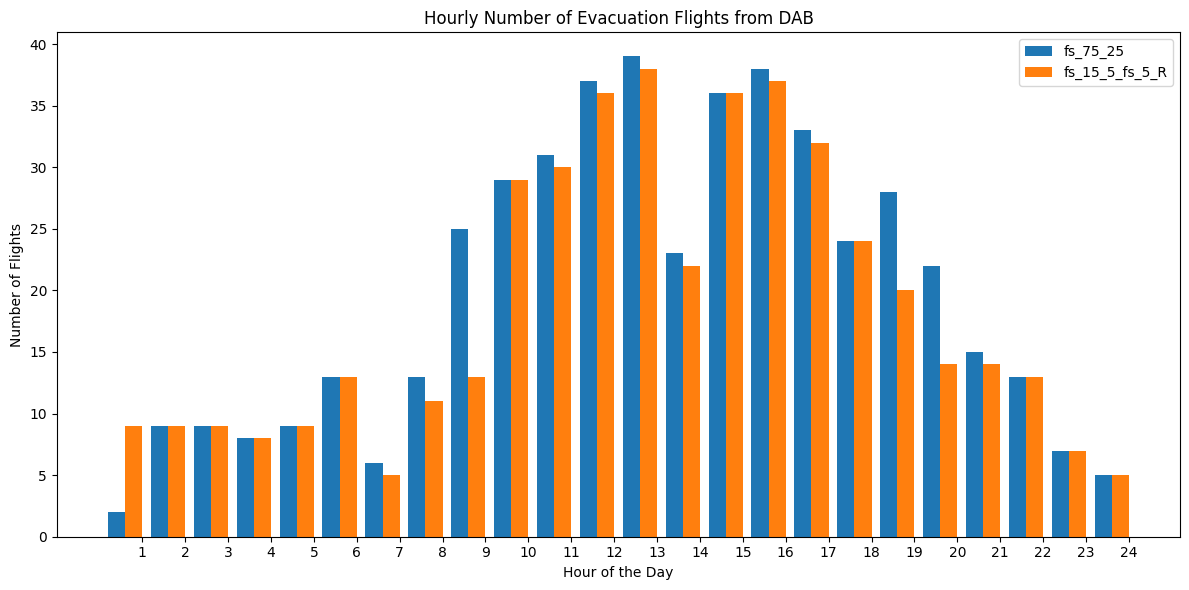

In [29]:
hours = list(range(1, 25))  # Hours from 1 to 24

bar_width = 0.4
index = np.arange(len(hours))

plt.figure(figsize=(12, 6))

plt.bar(index, fs_75_25, width=bar_width, label='fs_75_25')
plt.bar(index + bar_width, fs_15_5_fs_5_R, width=bar_width, label='fs_15_5_fs_5_R')

plt.xlabel('Hour of the Day')
plt.ylabel('Number of Flights')
plt.title('Hourly Number of Evacuation Flights from DAB')
plt.xticks(index + 1.5 * bar_width, hours)
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
# These are the fitness score which are obtained after running the above genetic algorithm for different combination of population size and generation
# To obtain these run the above genetic algorithm changing population size and generation

#This for population size 15 and generation of 5
fs_15_5=[0.5200942989242148, 1.0157274578574764, 1.2558777353723665, 0.9223428014420292, 1.032948956051916, 1.076213860201277, 1.009974551403479, 1.373598660845309, 1.6055405356739834, 1.42701268705598, 1.5234250430896528, 1.5807709958339264, 1.6161298617676345, 1.6625062624403475, 1.6680606518096819, 1.5380068740095632, 1.7812056520350839, 1.7621371334305782, 1.8264376096824457, 1.9412766990841255, 1.7132411280496216, 2.0397946384033108, 1.2813925374065616, 1.1597397121914435]

#This for population size 30 and generation of 10
fs_30_10=[0.6398836022072332, 1.02397442857096, 1.2558777353723665, 0.9739584857127719, 1.0438439445776266, 1.076213860201277, 1.2816308118970696, 1.5738392444133604, 1.6884667843047034, 1.8151241210080271, 1.7073611385249905, 1.7828209529369303, 1.7345323262361219, 1.6625062624403475, 1.8263144254228934, 1.8968449465582893, 1.9977713324695703, 1.7621371334305782, 1.9681793514241877, 1.9412766990841255, 1.9011984989399688, 2.038208922960587, 1.2813925374065616, 1.497720083380415]

#This for population size 75 and generation of 25
fs_75_25=[0.7820671261087556, 1.02397442857096, 1.2558777353723665, 0.9739584857127719, 1.0438439445776266, 1.076213860201277, 1.3653531895322877, 1.6369255557279538, 1.7153860436956612, 1.9050611430673212, 1.7073611385249905, 1.7828209529369303, 1.8010741154364363, 1.6625062624403475, 1.8263144254228934, 1.8968449465582893, 1.9977713324695703, 1.7621371334305782, 1.9681793514241877, 1.9412766990841255, 1.9011984989399688, 2.1478911685364057, 1.6198213401480035, 1.497720083380415]

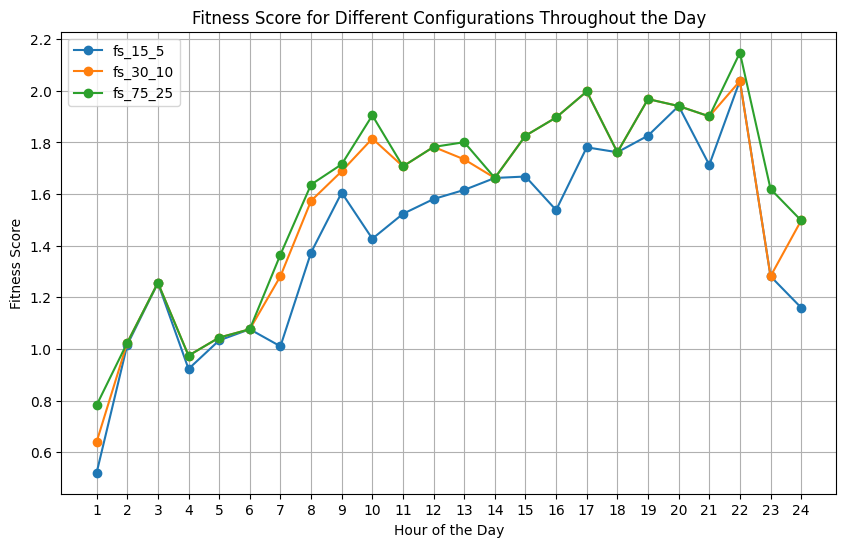

In [42]:
# Define the hours of the day for the x-axis
hours_of_day = list(range(1, 25))

# Plot the rewards
plt.figure(figsize=(10, 6))
plt.plot(hours_of_day, fs_15_5, label='fs_15_5', marker='o')
plt.plot(hours_of_day, fs_30_10, label='fs_30_10', marker='o')
plt.plot(hours_of_day, fs_75_25, label='fs_75_25', marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Fitness Score')
plt.title('Fitness Score for Different Configurations Throughout the Day')
plt.legend()
plt.grid(True)
plt.xticks(hours_of_day)
plt.show()